### Demo notebook for model trained on RSNA Pneumonia detection dataset

This notebook requires: 
```
pip install tensorflow==1.14.0
pip install keras==2.2.4
```

In [1]:
import sys
import os
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
from keras.utils.data_utils import get_file

# Root directory of the project
ROOT_DIR = os.path.abspath("./")

# Import Mask RCNN
sys.path.append("../") # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize

# Download trained weights from releases if needed
URL = "https://github.com/hasibzunair/cxr-predictor/releases/latest/download/RNSA_Pneumonia_MaskRCNN_7epochs.h5"
PNEUMONIA_MODEL_PATH = get_file(
           "RNSA_Pneumonia_MaskRCNN_7epochs.h5",
           URL)

Using TensorFlow backend.
/home/hasib/anaconda3/envs/thorax/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/hasib/anaconda3/envs/thorax/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/hasib/anaconda3/envs/thorax/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/hasib/anaconda3/e

In [2]:
# Get DetectorConfig from training script
class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """
    
    # Give the configuration a recognizable name  
    NAME = 'pneumonia'
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 2  # background + 1 pneumonia classes
    
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    #RPN_ANCHOR_SCALES = (16, 32, 64, 128) # Does not work properly on CPU
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 4
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.78  ## match target distribution
    DETECTION_NMS_THRESHOLD = 0.01
    STEPS_PER_EPOCH = 200
    
# Setup inference config
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()
inference_config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.78
DETECTION_NMS_THRESHOLD        0.01
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

### Create Model and Load Trained Weights

In [3]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

# Load trained weights
model.load_weights(PNEUMONIA_MODEL_PATH, by_name=True)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [4]:
# Load a random image from the images folder
file_names = "/home/hasib/Desktop/pneumothorax_rightside.jpeg"
image = skimage.io.imread(file_names)
if len(image.shape) == 2:
    # Convert to 3-channel
    image = np.stack((image, image, image), axis=-1)
image.shape

(686, 800, 3)

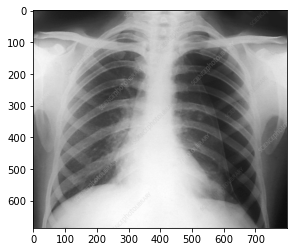

In [5]:
plt.imshow(image, cmap='gray')

### Run inference

In [6]:
# Run detection
results = model.detect([image], verbose=1)

Processing 1 images
image                    shape: (686, 800, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  800.00000  float64
anchors                  shape: (1, 16368, 4)         min:   -1.41976  max:    2.16878  float32


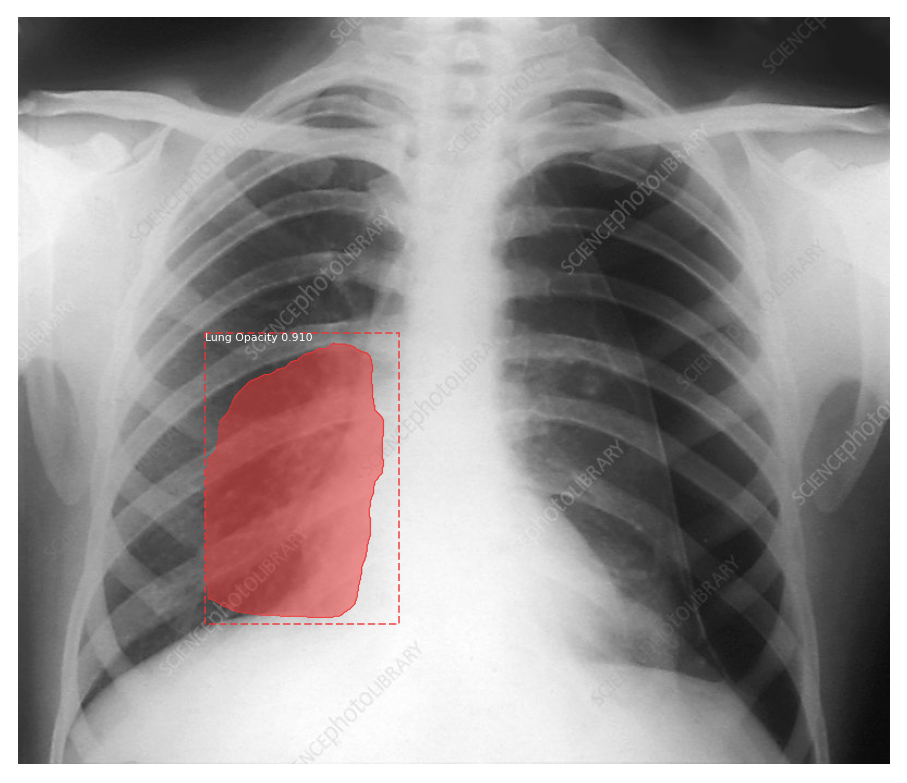

In [7]:
# set color for class
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors

# Visualize results
r = results[0]

if 1 not in r['class_ids']:
    print("There is no presence of pneumonia.")
else:
    visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                                ["None", "Lung Opacity"], r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']))

[289 172 557 350]


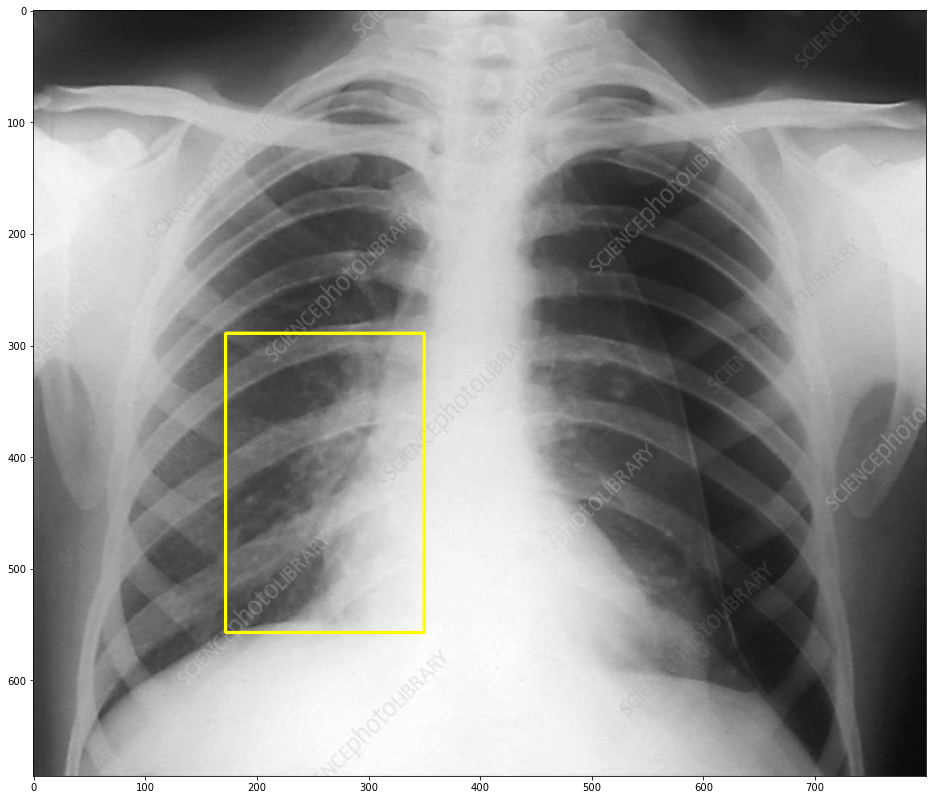

In [8]:
import cv2

r = results[0]
for bbox in r['rois']: 
    print(bbox)
    x1 = int(bbox[1])
    y1 = int(bbox[0])
    x2 = int(bbox[3])
    y2 = int(bbox[2])
    image = cv2.rectangle(image, (x1,y1), (x2,y2), (255, 255, 0), 2)
    
plt.figure(figsize=(16, 16)) 
plt.imshow(image, cmap=plt.cm.gist_gray)